In [89]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

In [90]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_name = '2017_12_01_10_06_57_readout-test'
exp_date = '_'.join(exp_name.split('_')[:3])
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
cuts = [[22],[2]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
ret = q.generate_thresholds()
q.set_thresholds(cuts)

In [91]:
q.experiments[0]['variable_list']
try:
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
except IndexError:
    xlab = 'iteration'

In [92]:
retention = q.apply_thresholds()

In [93]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.00	retention:0.930 +- 0.015


In [94]:
q.save_experiment_data()

<IPython.core.display.Javascript object>


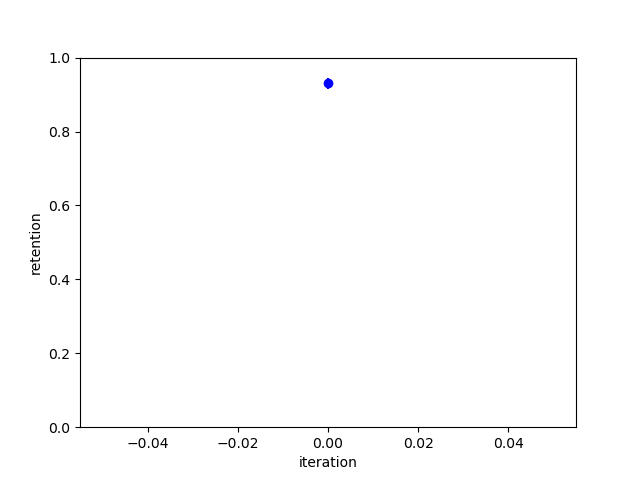

Text(0,0.5,u'retention')

In [95]:
fig, ax = plt.subplots()
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'bo'
    )
ax.set_ylim(0, 1)
ax.set_xlabel(xlab)
ax.set_ylabel('retention')

<IPython.core.display.Javascript object>


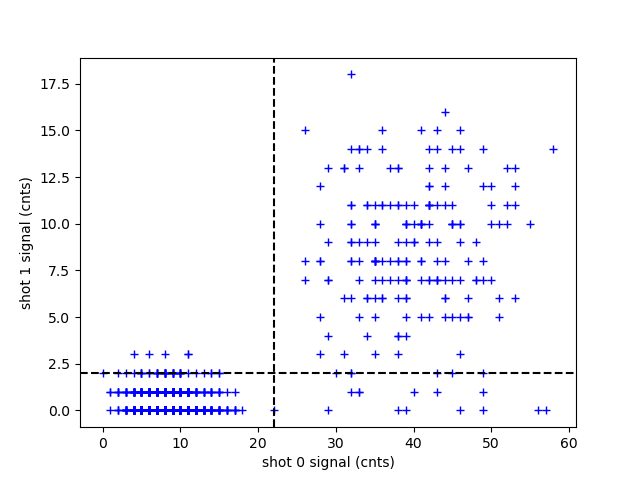

Text(0,0.5,u'shot 1 signal (cnts)')

In [96]:
itr = 0*(len(retention['ivar'][e])-1)
fig, ax = plt.subplots()
s0_data = q.experiments[0]['iterations'][itr]['signal_data'][:,0]
s1_data = q.experiments[0]['iterations'][itr]['signal_data'][:,1]
ax.plot(s0_data, s1_data, 'b+')

for xc in cuts[0]:
    plt.axvline(x=xc, color='k', linestyle='--')
for xc in cuts[1]:
    plt.axhline(y=xc, color='k', linestyle='--')

ax.set_xlabel('shot 0 signal (cnts)')
ax.set_ylabel('shot 1 signal (cnts)')

In [97]:
meas = q.experiments[0]['iterations'][0]['quantized_data']
lost = []
for m, qd in enumerate(meas):
    if qd[0] and not qd[1]:
        lost.append(m)

<IPython.core.display.Javascript object>


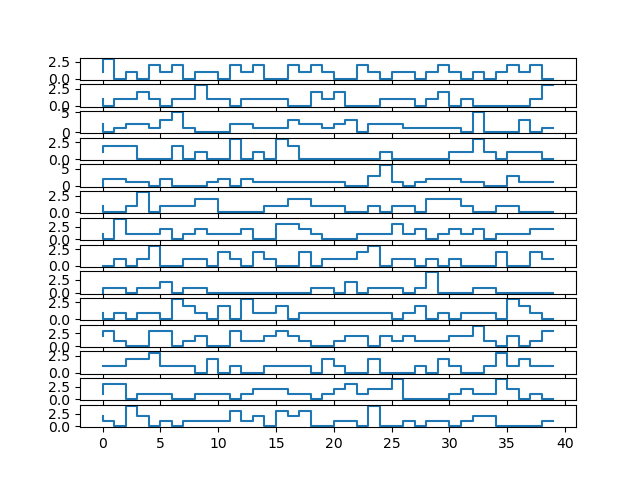

22.0|17.0 = 39.0
19.0|14.0 = 33.0
31.0|26.0 = 57.0
19.0|10.0 = 29.0
19.0|27.0 = 46.0
19.0|14.0 = 33.0
27.0|22.0 = 49.0
15.0|17.0 = 32.0
9.0|13.0 = 22.0
21.0|19.0 = 40.0
28.0|28.0 = 56.0
20.0|18.0 = 38.0
22.0|27.0 = 49.0
28.0|15.0 = 43.0


In [98]:
fig, ax = plt.subplots(len(lost), sharex=True)
for i, l in enumerate(lost):
    ax[i].step(range(40), q.experiments[0]['iterations'][0]['timeseries_data'][l,0])
    print("{}|{} = {}".format(
        np.sum(q.experiments[0]['iterations'][0]['timeseries_data'][l,0,:20]),
        np.sum(q.experiments[0]['iterations'][0]['timeseries_data'][l,0,-20:]),
        np.sum(q.experiments[0]['iterations'][0]['timeseries_data'][l,0])
    ))

In [99]:
print lost

[40, 71, 72, 82, 331, 422, 453, 491, 508, 725, 767, 769, 831, 1037]


In [100]:
s0 = ret[0]['fit_params'][2]
s1 = ret[0]['fit_params'][3] - s0
s2 = s1*2

In [101]:
s2

62.073061872960317

In [102]:
s0 + s1 + 2*np.sqrt(s0+s1)

51.727339607921493

In [103]:
s0 + s1 + 2*ret[0]['fit_params'][5]

54.613572861227141

In [104]:
## bright state liklihood
measurements, shots, bins = q.experiments[0]['iterations'][0]['timeseries_data'].shape
pbs = np.zeros(measurements)
pds = np.zeros(measurements)
i = 0
mu_b = (s0+s1)/bins  # mean bright signal per bin
mu_d = s0/bins  # mean dark signal per bin
for k in np.nditer(q.experiments[0]['iterations'][0]['timeseries_data'][:,0], flags=['external_loop']):
    pbs[i] = np.product(poisson.pmf(k, mu_b))
    pds[i] = np.product(poisson.pmf(k, mu_d))
    i += 1

In [105]:
loading_time_resolved = pbs > pds

In [112]:
np.sum(np.logical_xor(q.experiments[0]['iterations'][0]['quantized_data'][:,0], loading_time_resolved))

0

In [110]:
loading_time_resolved[:20]

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False, False], dtype=bool)

In [136]:
## bright state liklihood, assuming b -> d transition
measurements, shots, bins = q.experiments[0]['iterations'][0]['timeseries_data'].shape
atm_state = np.zeros(measurements, dtype='bool')
cps = np.zeros(measurements, dtype='int8')
i = 0
mu_b = (s0+s1)/bins  # mean bright signal per bin
mu_d = s0/bins  # mean dark signal per bin
for k in np.nditer(q.experiments[0]['iterations'][0]['timeseries_data'][:,0], flags=['external_loop']):
    lh_b = poisson.pmf(k, mu_b)
    lh_d = poisson.pmf(k, mu_d)
    pib = 0
    cp_max = 0
    for cp in xrange(bins):
        pib_new = np.product(lh_b[:cp])*np.product(lh_d[cp:])
        if pib_new > pib:
            pib = pib_new
            cp_max = cp
    atm_state[i] = cp_max != 0
    cps[i] = cp_max
    i += 1

In [137]:
np.sum(atm_state)

550

In [138]:
np.sum(loading_time_resolved)

201

In [139]:
np.sum(q.experiments[0]['iterations'][0]['quantized_data'][:,0])

201.0

In [140]:
np.sum(np.logical_and(atm_state,loading_time_resolved))

201